In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy import stats
import seaborn as sns

import star_utils
from gen_d_params import gen_d_params
from err_maps import err_maps
from dmap_compare import dmap_compare
from plot_error_maps import plot_error_maps
from star_utils import d2pd,d_all2pd

In [2]:
###############################################################################
sns.set_style("whitegrid")
f_size=15
sns.set_context(rc = {'axes.facecolor': ".9",
                      'legend.fontsize': f_size,
                      'figure.figsize': (15,5),
                      'figure.titlesize': f_size,
                      'xtick.labelsize': f_size,
                      'ytick.labelsize': f_size,
                      'font.size': f_size,
                      'axes.titlesize': f_size,
                      'axes.labelsize': f_size,
                      'lines.markersize': 10,     
                      'legend.markerscale': 2,     
                      'lines.markeredgewidth': 0.4,
                      'lines.linewidth': 3})
##############################################################################

# Load Star Images

In [3]:
data = star_utils.load_stars()
img_fits = star_utils.load_hi_res()
img_list = star_utils.img_list()

# Collect Image Statistics

In [4]:
clipped_data={}
median={}
std={}
med={}
for img in img_list:
    clipped_data[img]=stats.sigma_clip(img_fits[img],sigma=3,iters=5) #get stats on image
    med[img] = np.median(clipped_data[img])
    std[img] = np.std(clipped_data[img] - med[img])

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


# Plot Star Images

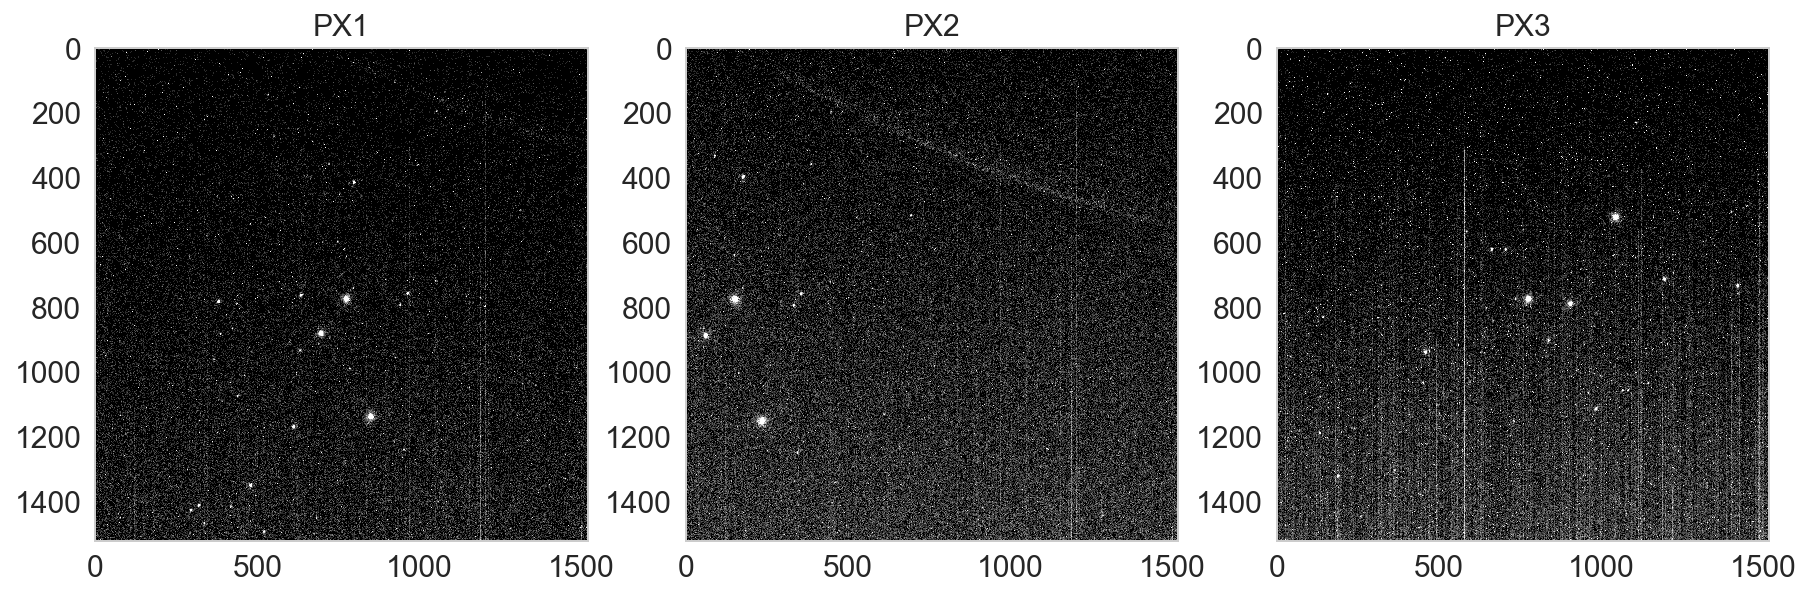

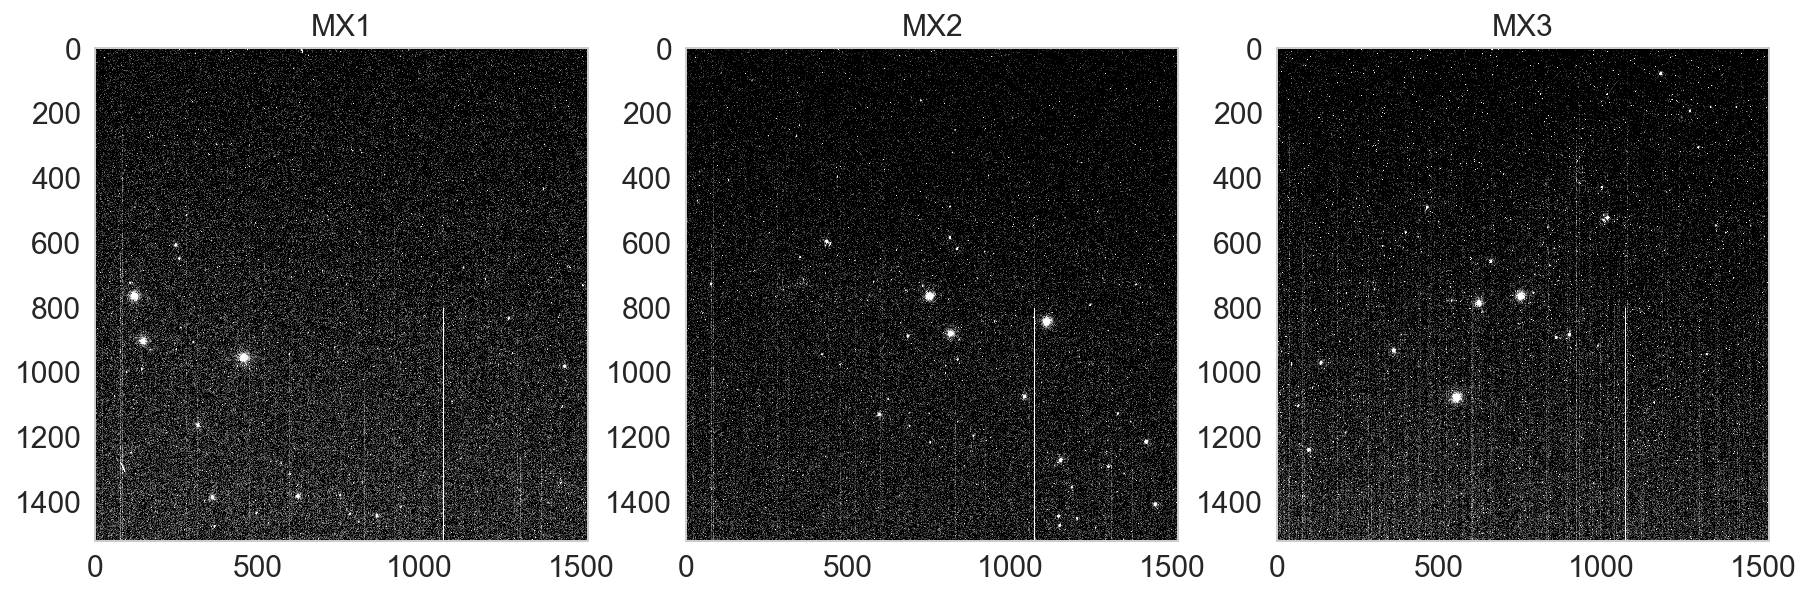

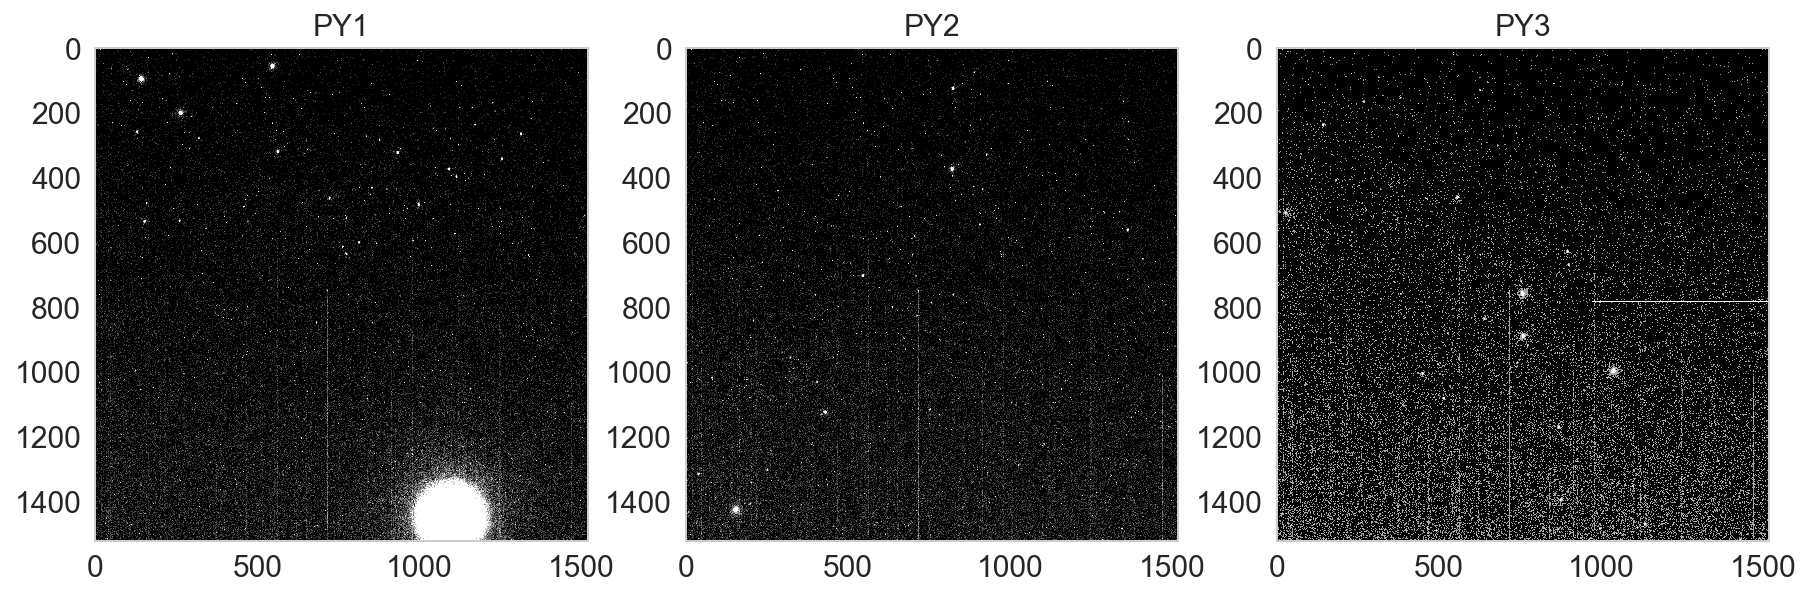

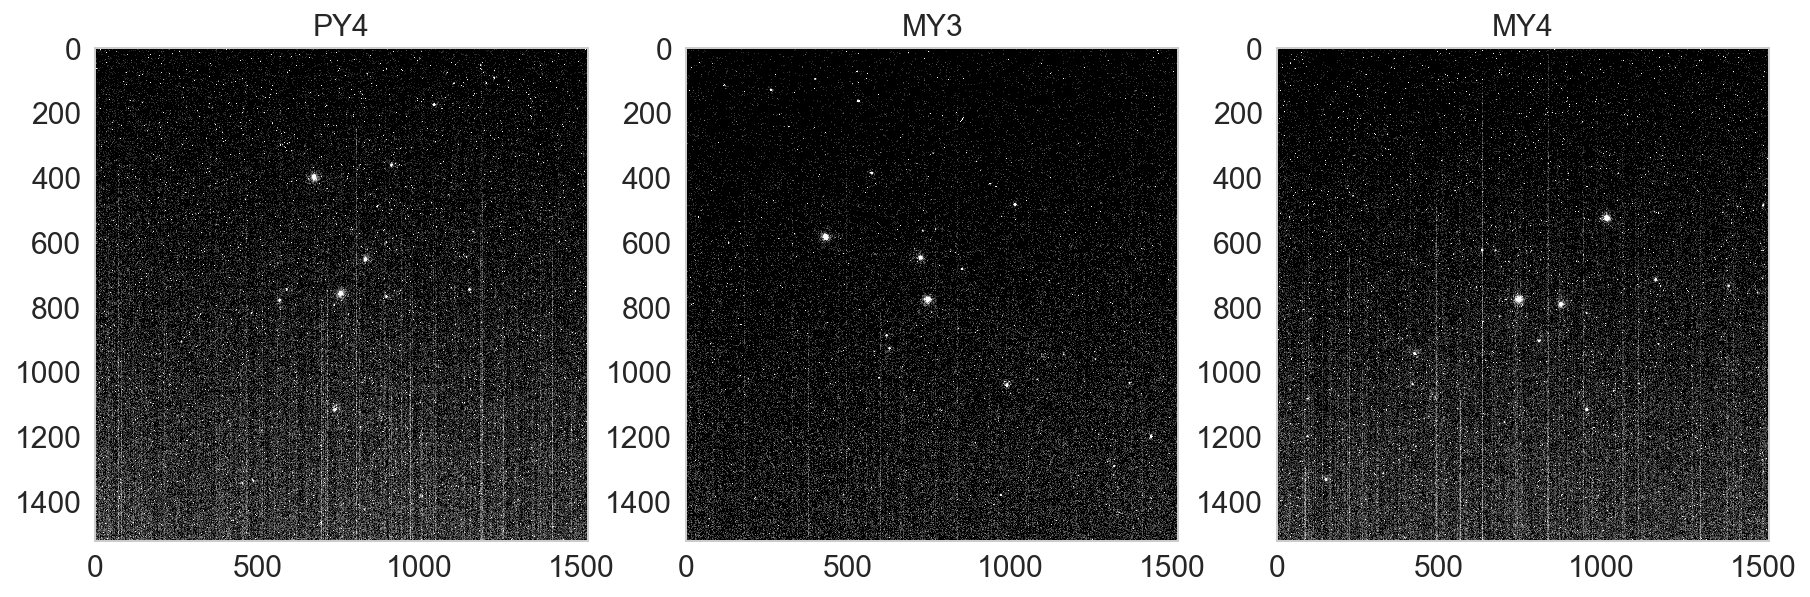

In [5]:
def plot_stars(img_list):
    fig, axs = plt.subplots(1,len(img_list), figsize=(15, 5), facecolor='w', edgecolor='k')
    fig.set_tight_layout(False)
    axs = axs.ravel()
    for i in range(len(img_list)):
        axs[i].imshow(img_fits[img_list[i]],vmin=med[img_list[i]],vmax=med[img_list[i]]+5*std[img_list[i]],cmap='gray')
        axs[i].set_title(img_list[i].upper())
        axs[i].grid(False)
plot_stars(['px1','px2','px3'])
plot_stars(['mx1','mx2','mx3'])
plot_stars(['py1','py2','py3'])
plot_stars(['py4','my3','my4'])

## Create Error Models
Each of the four cameras onboard CIPS captured a limited number (2-4) star images. From each star image, two sets of pixel locations are noted. 
#### 1) Ideal camera model coordinates (x_act,y_act)
First, starnames and the corresponding star coorindates (J2000) in each image are identified using Astrometry.net software. The star coordinates are transformed into image pixel coordinates using an ideal camera model and these resulting modeled pixel coordinates are referred to as (x_act,y_act).

#### 2) Star centroid coordinates (x_img,y_img)
Next, the centroids of all stars in each image are found using various techniques, and this resulting set of pixel coordinates is referred to collectively as (x_img,y_img).  

## Error Maps (x_img-x_act), (y_img-y_act)
Two sets of pixel error offsets can now be generated by simply taking the difference of the ideal coordinates and centroid coordinates. These discrete sets of error offsets can be populated with training data and used to model generic error maps on a 1520x1520 grid. 

Using various techniques, we will use a subset of images from each camera as a training set to create two 1520x1520 error maps (x-direction offset and y-direction offset) and then apply the error models to the testing set of star images.

The following figures illustrate the resulting error maps using three different tecniques: linear interpolation, nearest-neighbor search, and a 2d polyfitting algorithm.

In [6]:
#Load training/test data
#Training data: all stars from 'mx2' image
#Test data: all stars from 'mx3' image

train_set=['mx2']
test_set=['mx3']

d_orig_train = gen_d_params(train_set)
d_orig_test = gen_d_params(test_set)

fit=['linear','nearest','2d polyfit']
order=[None,None,2]
e_maps_linear,d_new_train_linear,d_new_test_linear = err_maps(d_orig_train,d_orig_test,fit[0],order[0])
e_maps_nearest,d_new_train_nearest,d_new_test_nearest = err_maps(d_orig_train,d_orig_test,fit[1],order[1])
e_maps_2dpoly,d_new_train_2dpoly,d_new_test_2dpoly = err_maps(d_orig_train,d_orig_test,fit[2],order[2])

d_params_train=[d_orig_train,d_new_train_2dpoly,d_new_train_nearest,d_new_train_linear]
d_params_test=[d_orig_test,d_new_test_2dpoly,d_new_test_nearest,d_new_test_linear]

d_labels_train=['original','2d polyfit','nearest','linear']
d_labels_test=['original','2d polyfit','nearest','linear']
col=['mag']
data_train = d_all2pd(d_params_train,d_labels_train,cols=col)
data_test = d_all2pd(d_params_test,d_labels_test,cols=col)

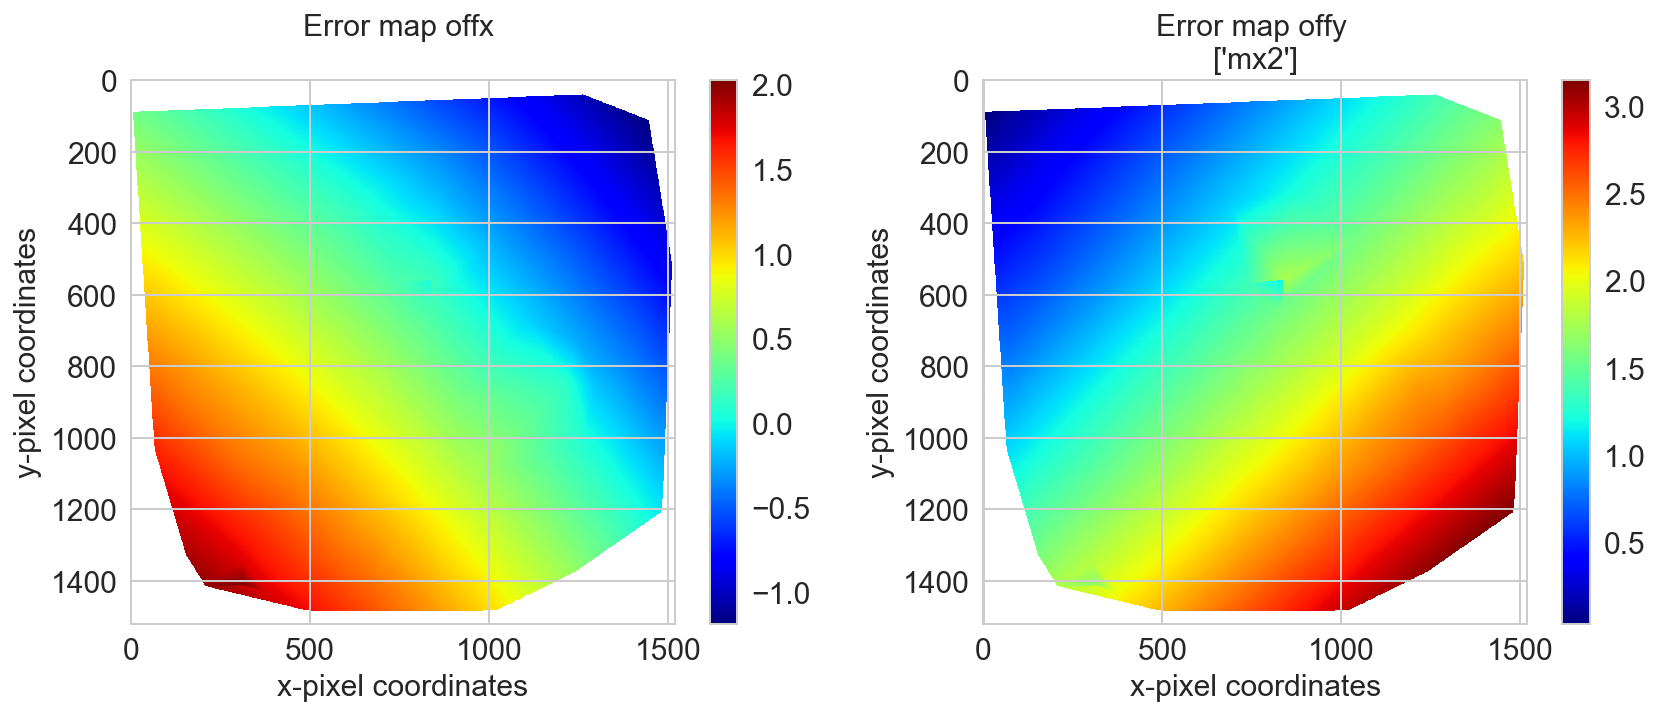

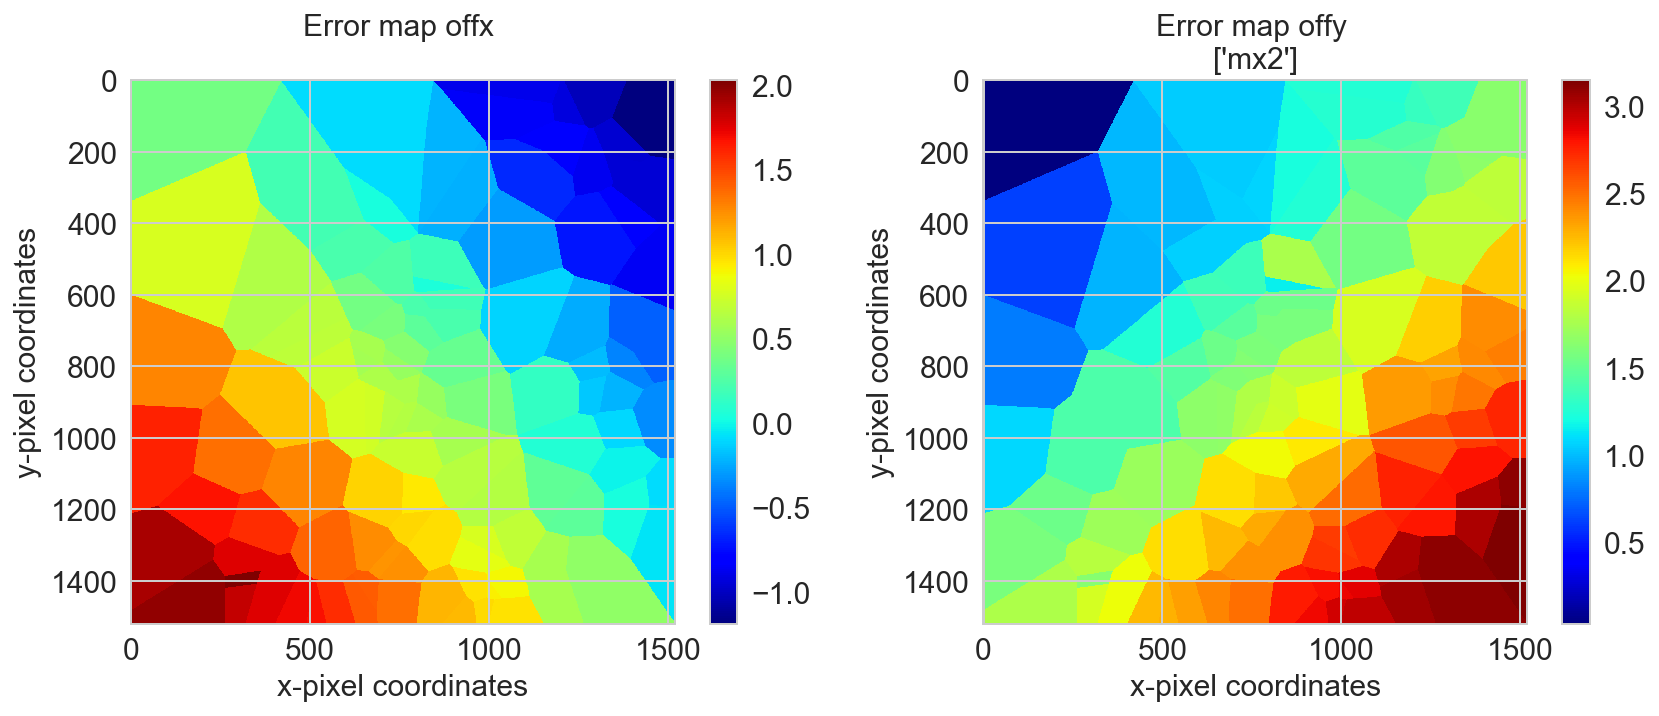

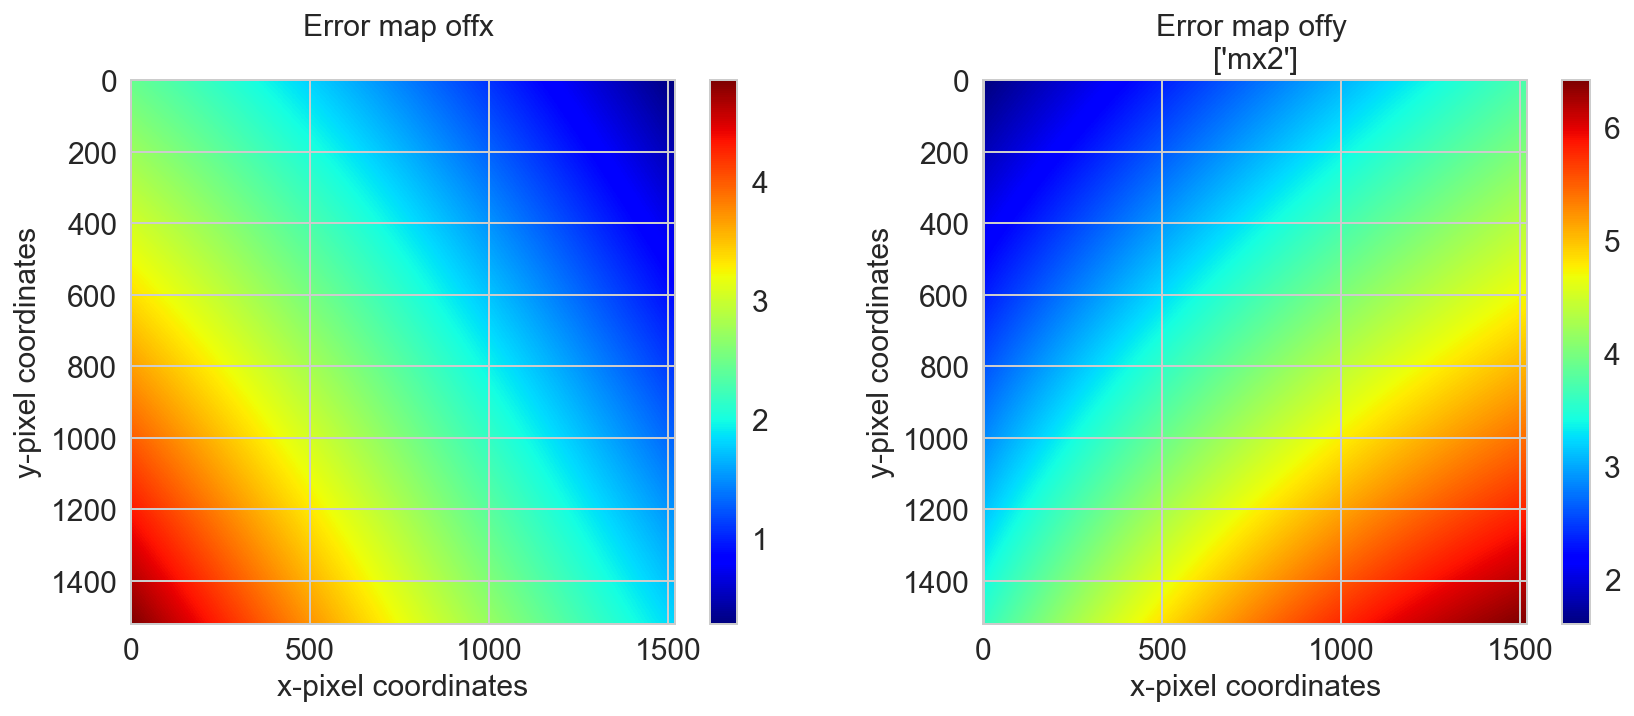

In [7]:
#Plot resulting error maps
plot_error_maps(d_orig_train,e_maps_linear)
plot_error_maps(d_orig_train,e_maps_nearest)
plot_error_maps(d_orig_train,e_maps_2dpoly)

## Distortion Maps:
### The following figures demonstrate the resulting error magnitudes of the Test dataset after application of the above error maps

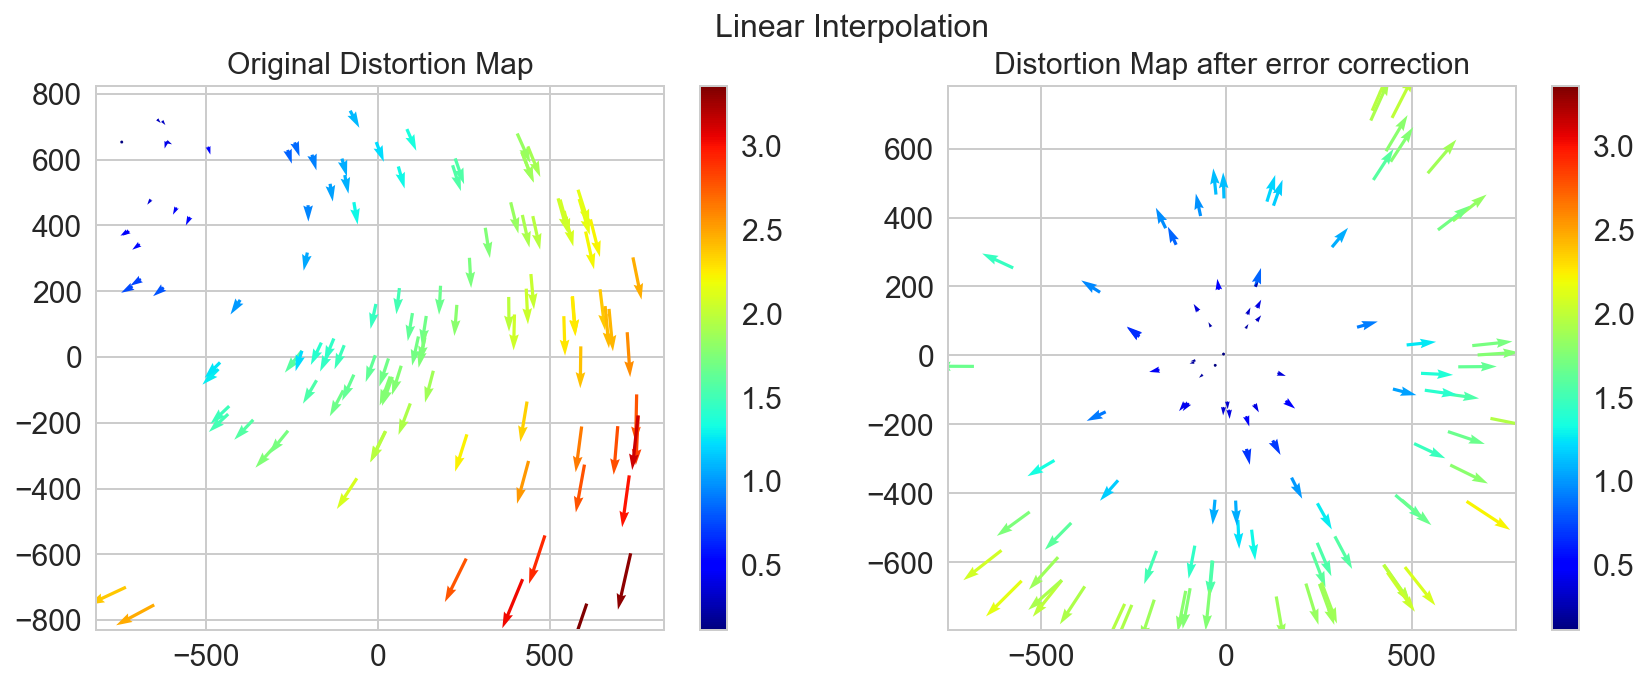

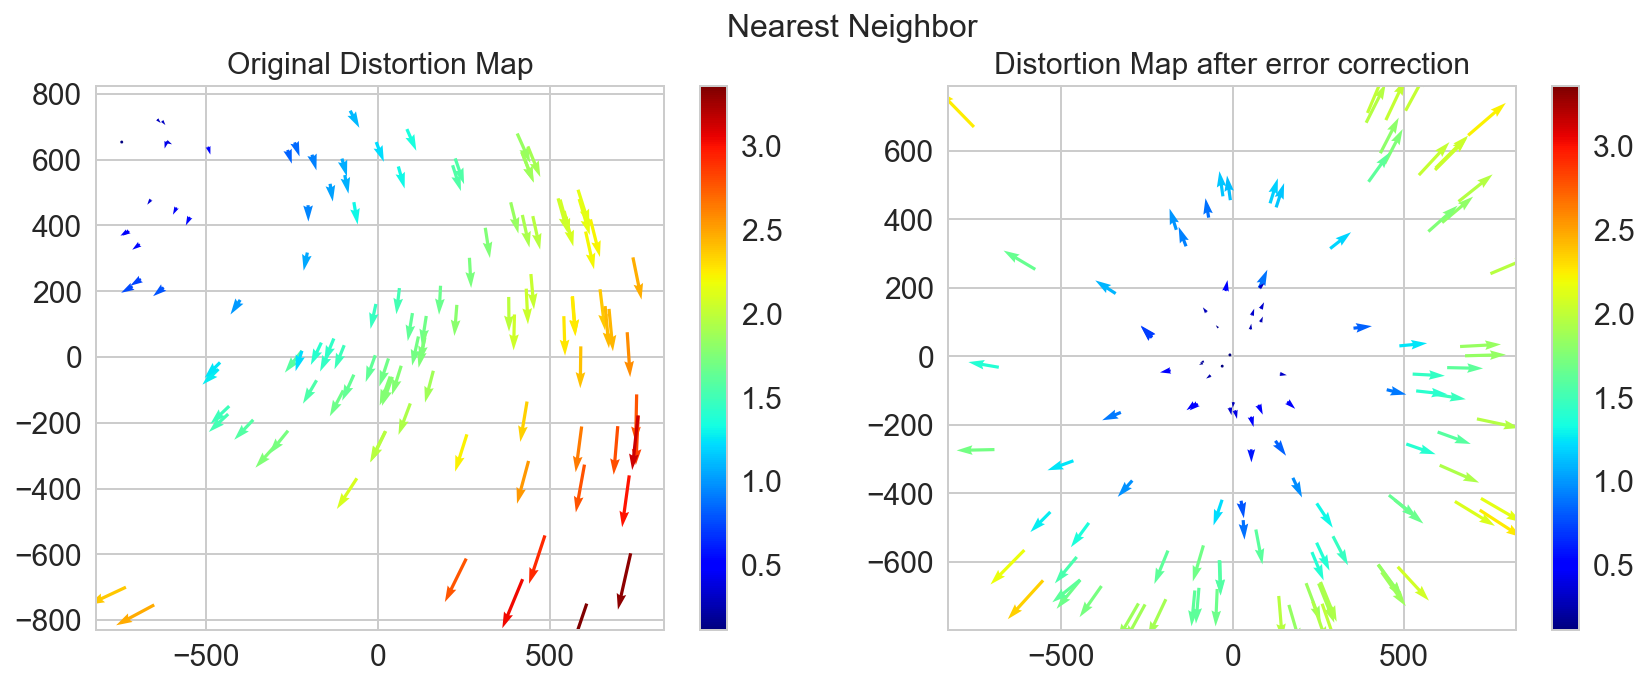

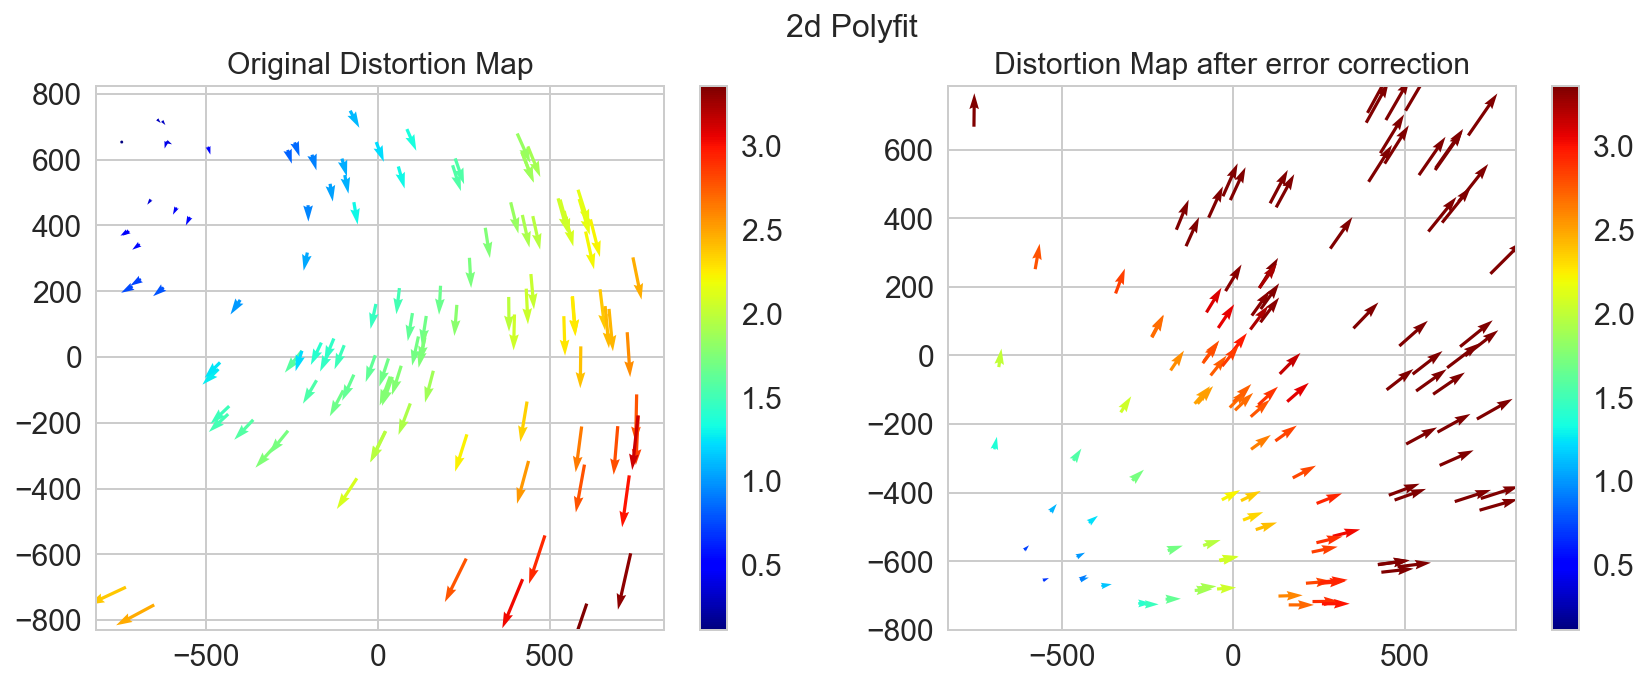

In [11]:
#Plot resulting distortion maps
dmap_compare(d_orig_train,d_orig_test,d_new_train_linear,d_new_test_linear,
            suptitle='Linear Interpolation')
dmap_compare(d_orig_train,d_orig_test,d_new_train_nearest,d_new_test_nearest,
            suptitle='Nearest Neighbor')
dmap_compare(d_orig_train,d_orig_test,d_new_train_2dpoly,d_new_test_2dpoly,
            suptitle='2d Polyfit')

## Error Mapping Stats:
### The following figures illustrate the ability of the different modeling techniques to reduce the overall error magnitude.

### The first figure shows the results of applying the error model to the training dataset, and the second figure shows the results of applying the error model to the testing dataset.

### The linear interpolation seemed decrease the magnitude of errors the best, followed closely by the nearest neighbor search. The 2d polyfitting algorithm actually increased the magnitude of errors.


C:\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


[Text(0,0,'mag_original'),
 Text(0,0,'mag_linear'),
 Text(0,0,'mag_nearest'),
 Text(0,0,'mag_2d polyfit')]

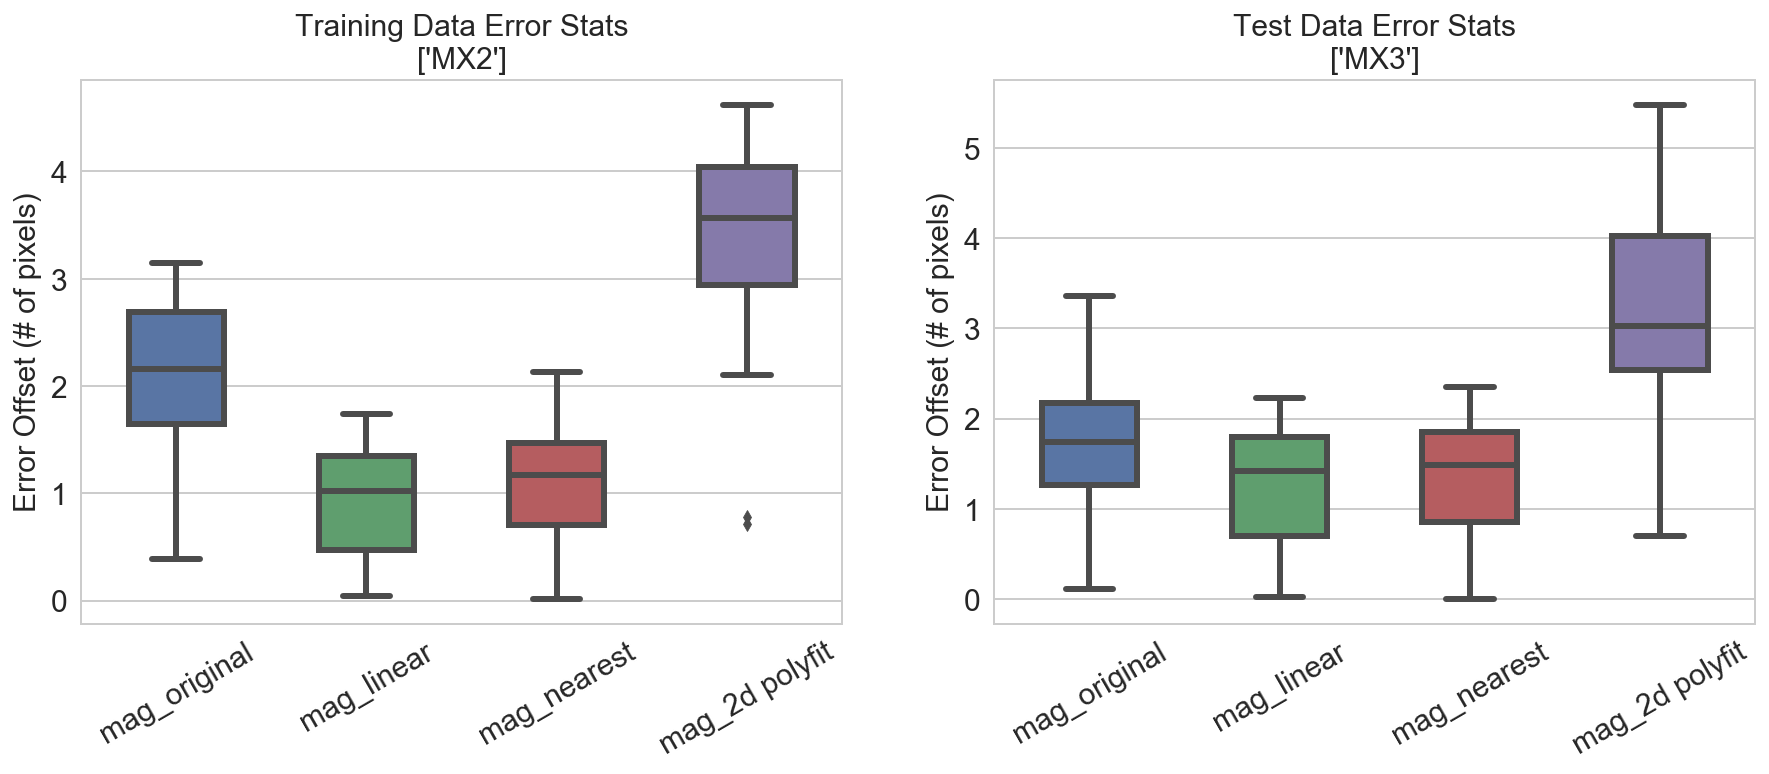

In [14]:
fig = plt.figure(figsize=(15, 5), facecolor='w', edgecolor='k')
fig.set_tight_layout(False)
width=0.5
plt.subplot(121)
plt.title('Training Data Error Stats\n'+str(train_set).upper())
ax1=sns.boxplot(data=data_train,order=["mag_original",
                                       "mag_linear",
                                       "mag_nearest",
                                       "mag_2d polyfit"],
                                       width=width)
ax1.set(ylabel='Error Offset (# of pixels)')
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=30)

plt.subplot(122)
plt.title('Test Data Error Stats\n'+str(test_set).upper())
ax2=sns.boxplot(data=data_test,order=["mag_original",
                                      "mag_linear",
                                      "mag_nearest",
                                      "mag_2d polyfit"],
                                       width=width)
ax2.set(ylabel='Error Offset (# of pixels)')
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=30)